In [4]:
"""
    Copyright (c) 2021 Olivier Leblanc

    Permission is hereby granted, free of charge, to any person obtaining
    a copy of this software and associated documentation files (the "Software"),
    to deal in the Software without restriction, including without limitation
    the rights to use, copy, modify, merge, publish, distribute, and to permit
    persons to whom the Software is furnished to do so.
    However, anyone intending to sublicense and/or sell copies of the Software
    will require the official permission of the author.
    ----------------------------------------------------------------------------

    Author : Olivier Leblanc
    Date : 14/06/2021

    Code description :
    __________________
    Generates sparse matrix and recover it 
    by solving an inverse problem from rank-one projections.
"""
import matplotlib.pyplot as plt
import numpy as np
from pyunlocbox import functions, solvers, acceleration
import time

import sys, os
def updir(d, n):
  for _ in range(n):
    d = os.path.dirname(d)
  return d
sys.path.append(os.path.join(updir(os.getcwd(), 3),'utils'))

from interferometric_lensless_imaging import * # ROP projectors, rmdiag,...
from graphics import *
from shepp_logan import phantom
set_plot_params() # Set the plot params

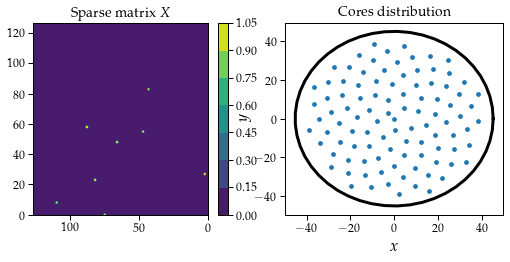

In [5]:
K = 8 # sparsity of matrix
N=128 # size of the image

"Create the sample space"
pos_x = np.random.randint(0, high=N, size=K)
pos_y = np.random.randint(0, high=N, size=K)
X = np.zeros((N,N))
"Define the sparse object"
for i in range(K):
    X[pos_x[i], pos_y[i]] = (-1)**i

"Fermat spiral"
Q = 100 # number of cores
diam_endo = np.sqrt(2)*(N/2) # Must be N for coherency between image resolution and cores distances
# diam_endo = N//2
pos_sources = LE_cores (diam_endo, Q, sources_shape = 'fermat')

"Define Om = {p_j - p_k, j,k \in [Q]}"
Om_x = np.subtract.outer(pos_sources[0,:], pos_sources[0,:]).astype(int)
Om_y = np.subtract.outer(pos_sources[1,:], pos_sources[1,:]).astype(int)

"Compute the multiplicity of each frequency"
multiplicities = ind_multiplicity(Om_x, Om_y)
multiplicities2 = np.ones((Q,Q))

"Plots"
fig = plt.figure(figsize=(7,4))
axs = subplot_axs(fig, 1,2)
im0 = axs[0].contourf(np.abs(X), cmap='viridis')
axs[0].invert_xaxis()
axs[0].set_title('Sparse matrix $X$')
fig.colorbar(im0, ax=axs[0])
theta = np.linspace(0,2*np.pi,50)
axs[1].plot(diam_endo/2*np.cos(theta), diam_endo/2*np.sin(theta), 'k', label='Borders')
cores = axs[1].scatter(pos_sources[0], pos_sources[1], marker='o', label='Sources', s = 15)
labels(axs[1], r'Cores distribution', '$x$', '$y$')

plt.show()

## Reconstruction from interferometric matrix $\boldsymbol{\mathcal{I}}_{\Omega}\left[f^\circ\right]$:
Solve 
$$
    \hat{\boldsymbol{f}^\circ} = \text{argmin}_{\boldsymbol{u}}~ \left\lVert \boldsymbol{u} \right\rVert_1 + \tau \left\lVert \boldsymbol{S}_{\Omega} \boldsymbol{T} \boldsymbol{u}-\boldsymbol{\mathcal{I}}_{\Omega} \right\rVert_2^2
$$

Solution found after 141 iterations:
    objective function f(sol) = 7.990038e+00-7.497565e-18j
    stopping criterion: RTOL


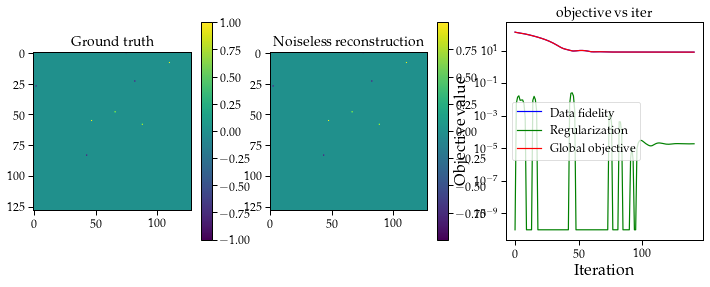

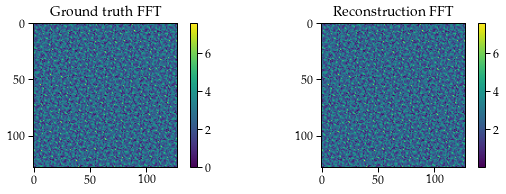

SNR: 58.08 dB
Elapsed time: 3.92s
Sparsity of the reconstruction: K=8


In [6]:
"Define single input function"
g = lambda Xin: S_Om(T(Xin), Om_x, Om_y, mult_mat=multiplicities)
gt = lambda Xin: np.real(T_star(S_Om_star(Xin, Om_x, Om_y, X.shape, mult_mat=multiplicities) ))

tic = time.time()
F=g(X)
tau=1e3 # weight between sparsity and data fidelity 
f1 = functions.norm_l1()
nu_rop = eval_nu(X, g, gt, nb_iter=50)*1.01
f2 = functions.norm_l2(y=F, A=g, At=gt, lambda_=tau, nu=nu_rop) 
solver = solvers.forward_backward(step=1/(2*tau*nu_rop) )

# x0 = np.zeros(X.shape)
x0 = gt(F) 
Xhat_data = solvers.solve([f2, f1], x0, solver, rtol=1e-7, maxit=1000)
Xhat = Xhat_data['sol']
objective = np.array(Xhat_data['objective'])
objective[objective<1e-10]=1e-10
show_rec2D(X, Xhat, objective=objective, show_Fourier=True)

tac = time.time()
print('Elapsed time: {:.2f}s'.format(tac-tic) )

print('Sparsity of the reconstruction: K={}'.format(np.sum(np.abs(Xhat)>1e-8)) )